# Volume Estimation 

In this notebook we will estimate the volume of the eddies defined by the three methods py-eddy-tracker, 2D VoCC, and 3D VoCC.
For the two dimensional methods we utilize the bathymetry as depth estimation.

In [1]:
from py_eddy_tracker.dataset.grid import UnRegularGridDataset
from datetime import datetime
import numpy as np
from shapely.geometry import Polygon
from VoCC import VortexCorrelationClustering
from shapely.geometry import Point, MultiPolygon
import matplotlib.pyplot as plt
from cartopy.crs import PlateCarree
from cartopy.feature import LAND, COASTLINE
import xarray as xr
import area

%run ../scripts/experiment_utils.py

DEPTH_STRIDE = 6
MIN_PARTICLES = 40


font_size = 16

In [2]:
# set plotlib fontsize to 16
plt.rcParams.update({'font.size': 14})

## Preperation

In [3]:
def get_py_eddy_tracker_labels():
    g = UnRegularGridDataset('../data/ssh_u_v_1d_20111029.nc',
                        'nav_lon', 'nav_lat', centered=True)
    g.high_filter('ssh',w_cut=700,factor=8.0)
    date = datetime(2011,10,29)
    a,c = g.eddy_identification('ssh', 'u', 'v', date = date, step=0.004, shape_error=70)


    # Load the particles dataset

    coordinates = np.load('../data/particles_29102011.npy')
    X,Y,U,V = coordinates[::3].T

    # The magnitude of the movement are two days we normalize them to one.
    U /= 2
    V /= 2
    # Set outliers to zero
    U[U > 1] = 0
    V[V > .5] = 0

    def extract_lagrangian_eddies(eddy_dataset, particles_x, particles_y, particle_threshold):
        counts, _ = np.histogram(eddy_dataset.contains(particles_x, particles_y), bins = np.arange( len(eddy_dataset)+1))
        mask_indices = np.argwhere(counts >= particle_threshold).squeeze()

        mask = np.zeros(len(eddy_dataset.obs), dtype=bool)
        mask[mask_indices] = True

        return eddy_dataset.extract_with_mask(mask)


    particle_eddy_a = extract_lagrangian_eddies(a, X, Y, MIN_PARTICLES).contains(coordinates[:,0],coordinates[:, 1])
    particle_eddy_c = extract_lagrangian_eddies(c, X, Y, MIN_PARTICLES).contains(coordinates[:,0],coordinates[:, 1])

    particle_eddy_c[particle_eddy_c >= 0] += particle_eddy_a.max() +1

    particle_eddy_labels = np.max(np.vstack((particle_eddy_a, particle_eddy_c)), axis = 0)
    return particle_eddy_labels, a, c

particle_eddy_labels, a, c = get_py_eddy_tracker_labels()

In [4]:
shell_coordinates_a = np.stack([a.contour_lon_s, a.contour_lat_s]).transpose(1,2,0)
shell_coordinates_c = np.stack([c.contour_lon_s, c.contour_lat_s]).transpose(1,2,0)

In [5]:
coordinates = np.load('../data/particles_29102011_depth.npy')
X,Y,U,V,D = coordinates.T

# The magnitude of the movement are two days we normalize them to one.
U /= 2
V /= 2
# Set outliers to zero
U[U > 1] = 0
V[V > .5] = 0

In [6]:
twod_vocc = VortexCorrelationClustering(
    radii=np.arange(4,24,4),
    cell_size= .07, 
    sectors = 15, 
    circle_coverage_rate = .75, 
    qth_threshold = .99, 
    min_points = .01,
)
two2_vocc_labels = twod_vocc.fit(coordinates).labels_

In [7]:
vocc = VortexCorrelationClustering(
    radii=np.arange(4,24,4),
    cell_size= .07, 
    sectors = 15, 
    circle_coverage_rate = .75, 
    qth_threshold = .99, 
    min_points = .01,
    depth_boundaries=-depth_layers[::DEPTH_STRIDE]
)
default_labels = vocc.fit(coordinates).labels_

<GeoAxes: >

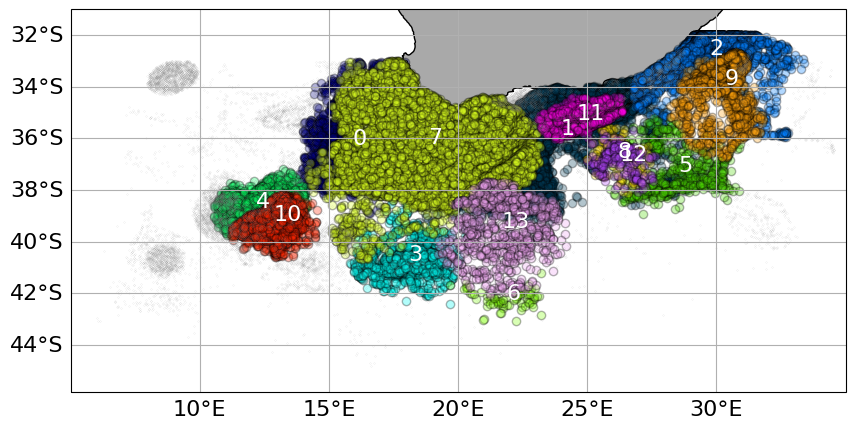

In [8]:
create_real_world_image(coordinates, default_labels, f'65_vocc_clustering_{DEPTH_STRIDE}', True)

## Volume estimation

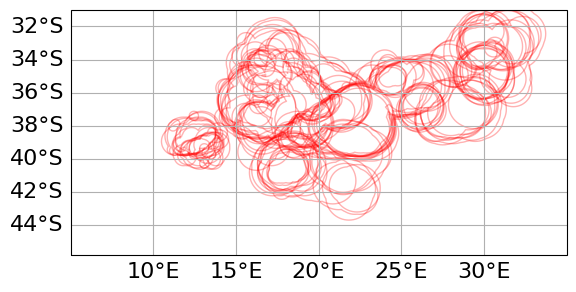

In [9]:
# Merge all outlines of the vortices 

fig = plt.figure()
ax = fig.add_subplot(1,1,1, projection=PlateCarree())

for vortex in vocc.vortices_:
    areas = []

    vortex_union = None
    vortex.depth_polygon = []

    for d_i, d in enumerate(np.unique(vortex.pixels[:, 3])):
        depth_mask = vortex.pixels[:, 3] == d
        out_side_polygon = None
        for (circle_x, circle_y), radius in zip(vortex.get_circle_positions()[depth_mask], vortex.get_circle_radii()[depth_mask]): 
      
                
            circle_x = circle_x * vocc.cell_size + vocc.min_positions[0]
            circle_y = circle_y * vocc.cell_size + vocc.min_positions[1]
            radius = radius * vocc.cell_size
            # ax.add_patch(Circle((circle_x, circle_y), radius, fill=False, color='red'))

            abc = Point(circle_x, circle_y).buffer(radius)
            
            if out_side_polygon is None:
                out_side_polygon = abc
            else:
                out_side_polygon = out_side_polygon.union(abc)


        if out_side_polygon is not None:
            
            ax.add_geometries([out_side_polygon], crs=PlateCarree(), edgecolor='red', facecolor = 'none', alpha=.3)
            if vortex_union is None:
                vortex_union = out_side_polygon
            else:
                vortex_union = vortex_union.union(out_side_polygon)

            vortex.depth_polygon.append(out_side_polygon)
    
    vortex.union = vortex_union


gl = ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False)
gl.top_labels, gl.right_labels = False, False
gl.xlabel_style, gl.ylabel_style = {'fontsize': font_size}, {'fontsize': font_size}

lat_min = -45
lat_max = -31
lon_min = 5
lon_max = 35
ax.set_extent([lon_min, lon_max, lat_min, lat_max])


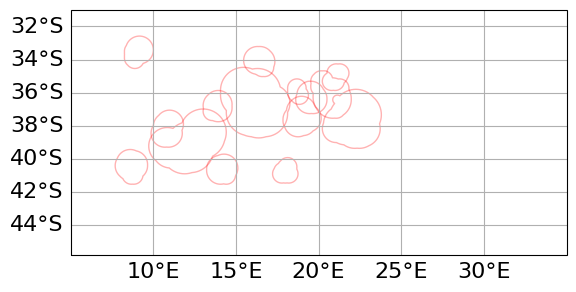

In [10]:
# For two dimensional VoCC

fig = plt.figure()
ax = fig.add_subplot(1,1,1, projection=PlateCarree())

for vortex in twod_vocc.vortices_:
    areas = []

    vortex_union = None
    vortex.depth_polygon = []

    out_side_polygon = None
    for (circle_x, circle_y), radius in zip(vortex.get_circle_positions(), vortex.get_circle_radii()): 
    
            
        circle_x = circle_x * vocc.cell_size + vocc.min_positions[0]
        circle_y = circle_y * vocc.cell_size + vocc.min_positions[1]
        radius = radius * vocc.cell_size
        # ax.add_patch(Circle((circle_x, circle_y), radius, fill=False, color='red'))

        abc = Point(circle_x, circle_y).buffer(radius)
        
        if out_side_polygon is None:
            out_side_polygon = abc
        else:
            out_side_polygon = out_side_polygon.union(abc)


    if out_side_polygon is not None:
        
        ax.add_geometries([out_side_polygon], crs=PlateCarree(), edgecolor='red', facecolor = 'none', alpha=.3)
        if vortex_union is None:
            vortex_union = out_side_polygon
        else:
            vortex_union = vortex_union.union(out_side_polygon)

        vortex.depth_polygon.append(out_side_polygon)
    
    vortex.union = vortex_union


gl = ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False)
gl.top_labels, gl.right_labels = False, False
gl.xlabel_style, gl.ylabel_style = {'fontsize': font_size}, {'fontsize': font_size}

lat_min = -45
lat_max = -31
lon_min = 5
lon_max = 35
ax.set_extent([lon_min, lon_max, lat_min, lat_max])

### Assign py-eddy-tracker eddies to the others

In [11]:
py_eddies = np.concatenate((shell_coordinates_a, shell_coordinates_c), axis = 0)


for vortex in vocc.vortices_:
    
    max_area = 0
    max_area_index = -1

    for py_eddy_i, py_eddy in enumerate(py_eddies):

        if vortex.union.intersects(Polygon(py_eddy)):
            intersection = vortex.union.intersection(Polygon(py_eddy))
            if intersection.area > max_area:
                max_area = intersection.area
                max_area_index = py_eddy_i

    print(max_area_index, max_area)

    vortex.py_eddy_index = max_area_index

    max_area = 0
    max_area_index = -1

    for td_eddy_i, td_eddy in enumerate(twod_vocc.vortices_):

        if vortex.union.intersects(td_eddy.union):
            intersection = vortex.union.intersection(td_eddy.union)
            if intersection.area > max_area:
                max_area = intersection.area
                max_area_index = td_eddy_i


    vortex.twod_vocc = max_area_index


69 1.9875685480710672
73 1.2964394316695689
86 0.6697328938813114
78 1.864213818549615
75 1.9262225971961016
73 1.2964394316695689
67 1.1891414531673945
69 1.9504423647375577
73 0.622592897855479
86 0.7029026092241111
75 1.3290371456390437
169 0.06388118249378749
73 0.7237143058618875
171 1.8791775683494052


In [12]:
# Calculate volumes
bathemetry = xr.open_dataarray('../data/bathymetry.nc')

stride_depth_layers = depth_layers[::DEPTH_STRIDE]
delta_z = stride_depth_layers - np.concatenate([[0], stride_depth_layers])[:-1] 
delta_z = np.concatenate([[0], delta_z])

height_per_layer = delta_z[:-1] / 2 + delta_z[1:] / 2 

volumes = []

for vortex in vocc.vortices_:
    py_eddy_center_y = np.atleast_1d(Polygon(py_eddies[vortex.py_eddy_index]).centroid.xy[1])[0]
    py_eddy_center_x = np.atleast_1d(Polygon(py_eddies[vortex.py_eddy_index]).centroid.xy[0])[0]


    maximum_dist = np.maximum(np.abs(bathemetry.nav_lat - py_eddy_center_y), np.abs(bathemetry.nav_lon - py_eddy_center_x))

    c = np.argmin(maximum_dist.values)
    x_index, y_index = np.unravel_index(c, maximum_dist.shape)

    depth = bathemetry.isel(x = x_index, y = y_index).values

    py_eddy_area = area.area({"type": 'Polygon', "coordinates":[py_eddies[vortex.py_eddy_index].tolist()]})
    py_eddy_volume =  py_eddy_area * depth 

    twod_lons = np.atleast_1d(twod_vocc.vortices_[vortex.twod_vocc].union.exterior.coords.xy[0])
    twod_lats = np.atleast_1d(twod_vocc.vortices_[vortex.twod_vocc].union.exterior.coords.xy[1])
    twod_coords = np.stack((twod_lons, twod_lats)).T

    twod_eddy_area = area.area({"type": 'Polygon', "coordinates":[twod_coords.tolist()]})
    twod_eddy_volume =  twod_eddy_area * depth

    volume_vocc = 0
    for depth_i, d in enumerate(np.unique(vortex.pixels[:, 3])):
        # check if depth_polyon is a MultiPolygon and take the area of all polygons
        if isinstance(vortex.depth_polygon[depth_i], MultiPolygon):

            area_vocc = 0
            for polygon in vortex.depth_polygon[depth_i].geoms:
                lons = np.atleast_1d(polygon.exterior.coords.xy[0])
                lats = np.atleast_1d(polygon.exterior.coords.xy[1])
                coords = np.stack((lons, lats)).T
                area_vocc += area.area({"type": 'Polygon', "coordinates":[coords.tolist()]})

        else:
            lons = np.atleast_1d(vortex.depth_polygon[depth_i].exterior.coords.xy[0])
            lats = np.atleast_1d(vortex.depth_polygon[depth_i].exterior.coords.xy[1])
            coords = np.stack((lons, lats)).T
            
            area_vocc = area.area({"type": 'Polygon', "coordinates":[coords.tolist()]})

        
        volume_vocc += area_vocc * height_per_layer[int(d)]
        # print(height_per_layer[int(d)], stride_depth_layers[int(d)] - stride_depth_layers[int(d) + 1])
        
    
    print(f'py_eddy_volume: {py_eddy_volume / 1000**3:.2f}, 3D_vocc_volume: {volume_vocc / 1000**3:.2f}', f'2D_vocc_volume: {twod_eddy_volume / 1000**3:.2f}', 'vocc percentage:', f'{volume_vocc / py_eddy_volume * 100:.4f}%')
    volumes.append((py_eddy_volume, volume_vocc, twod_eddy_volume))
    

volumes = np.array(volumes)
    

py_eddy_volume: 103797.05, 3D_vocc_volume: 236844.98 2D_vocc_volume: 733426.79 vocc percentage: 228.1808%
py_eddy_volume: 65376.71, 3D_vocc_volume: 392153.61 2D_vocc_volume: 499331.80 vocc percentage: 599.8369%
py_eddy_volume: 35432.32, 3D_vocc_volume: 199352.70 2D_vocc_volume: 264412.24 vocc percentage: 562.6296%
py_eddy_volume: 83294.82, 3D_vocc_volume: 154282.59 2D_vocc_volume: 82936.56 vocc percentage: 185.2247%
py_eddy_volume: 95769.31, 3D_vocc_volume: 39598.53 2D_vocc_volume: 622991.27 vocc percentage: 41.3478%
py_eddy_volume: 65376.71, 3D_vocc_volume: 116710.77 2D_vocc_volume: 274892.49 vocc percentage: 178.5204%
py_eddy_volume: 40519.77, 3D_vocc_volume: 56361.91 2D_vocc_volume: 197587.30 vocc percentage: 139.0973%
py_eddy_volume: 103797.05, 3D_vocc_volume: 251923.99 2D_vocc_volume: 733426.79 vocc percentage: 242.7082%
py_eddy_volume: 65376.71, 3D_vocc_volume: 3299.67 2D_vocc_volume: 274892.49 vocc percentage: 5.0472%
py_eddy_volume: 35432.32, 3D_vocc_volume: 73838.17 2D_vocc_vo

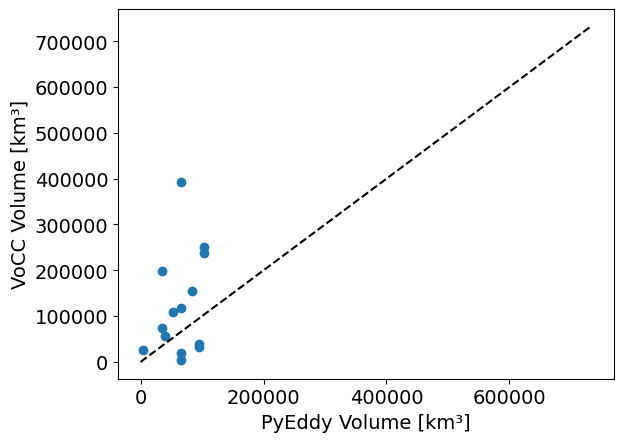

In [13]:
plt.plot(volumes[:,0] / 1000**3, volumes[:,1] / 1000**3, 'o')
plt.xlabel('PyEddy Volume [km³]')
plt.ylabel('VoCC Volume [km³]')

plt.plot([0, np.max(volumes) / 1000**3], [0, np.max(volumes) / 1000**3], 'k--')

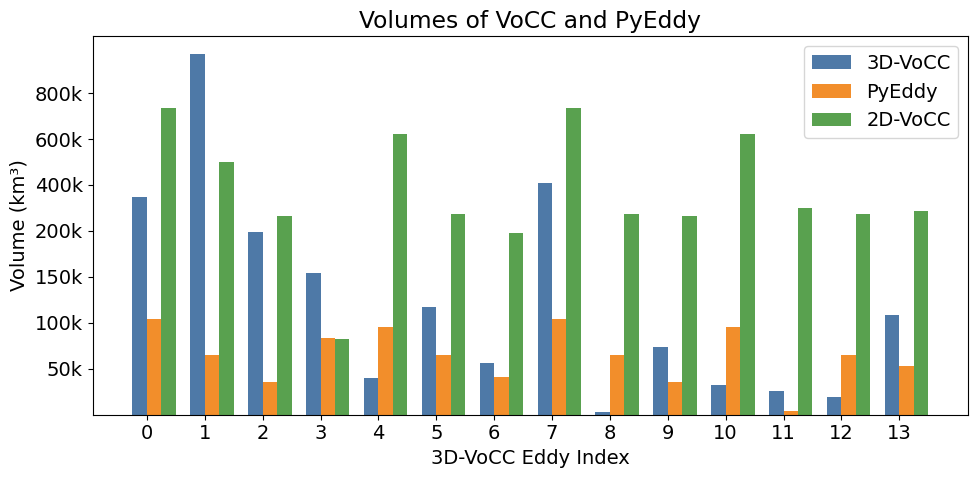

In [14]:


#make a bar plot of the volumes with vocc and py_eddy beneath each other
import matplotlib.pyplot as plt

# Calculate the number of vortices
num_vortices = len(volumes)

# Create a list of indices for the vortices
indices = list(range(num_vortices))

# Calculate the width of each bar
bar_width = 0.25

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(10, 5))

# Create the bars for VoCC volumes
vocc_bars = ax.bar(indices, volumes[:, 1] / 1000**3, bar_width, label='3D-VoCC', color = '#4E79A7')
py_eddy_bars = ax.bar([i + bar_width for i in indices], volumes[:, 0] / 1000**3, bar_width, label='PyEddy', color = '#F28E2B')

f = 4


twod_vocc_bars = ax.bar([i + 2*bar_width for i in indices],np.where(volumes[:, 2]/ 1000**3 > 200_000, 200_000 + (volumes[:,2 ]/ 1000**3 - 200_000) / f, volumes[:, 2]/ 1000**3) , bar_width, label='2D-VoCC', color = '#59A14F')

# Create the bars for PyEddy volumes


# Set the x-axis labels
ax.set_xticks([i + bar_width / 2 for i in indices])
ax.set_xticklabels(indices)

# Set the y-axis label
ax.set_ylabel('Volume (km³)')

# Set the title
ax.set_title('Volumes of VoCC and PyEddy')

# Add a legend
ax.legend()

#make the scala of the y axis normal up to 200_000 and then with a step of 100_000
ax.set_yticks(np.arange(0, 200_000, 100_000))

ax.set_yticks([50_000, 100_000, 150_000, 200_000] + [200_000 + 200_000 / f, 200_000 + 400_000 / f, 200_000 + 600_000 / f], ['50k', '100k', '150k', '200k'] + ['400k', '600k', '800k'])

# ax.set_ylim(0, 300_000)
ax.set_xlabel('3D-VoCC Eddy Index')

# Show the plot
fig.tight_layout()

plt.savefig('../fig/65_3dvocc-volumes.png')

###  Show a single eddy in the depth with contour and particles

(6769, 5)
(7007, 5)
(4529, 5)


/tmp/ipykernel_3626426/3950837506.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_zticklabels([f"{-i}m" for i in range(-1400, 201, 200)])
/tmp/ipykernel_3626426/3950837506.py:56: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


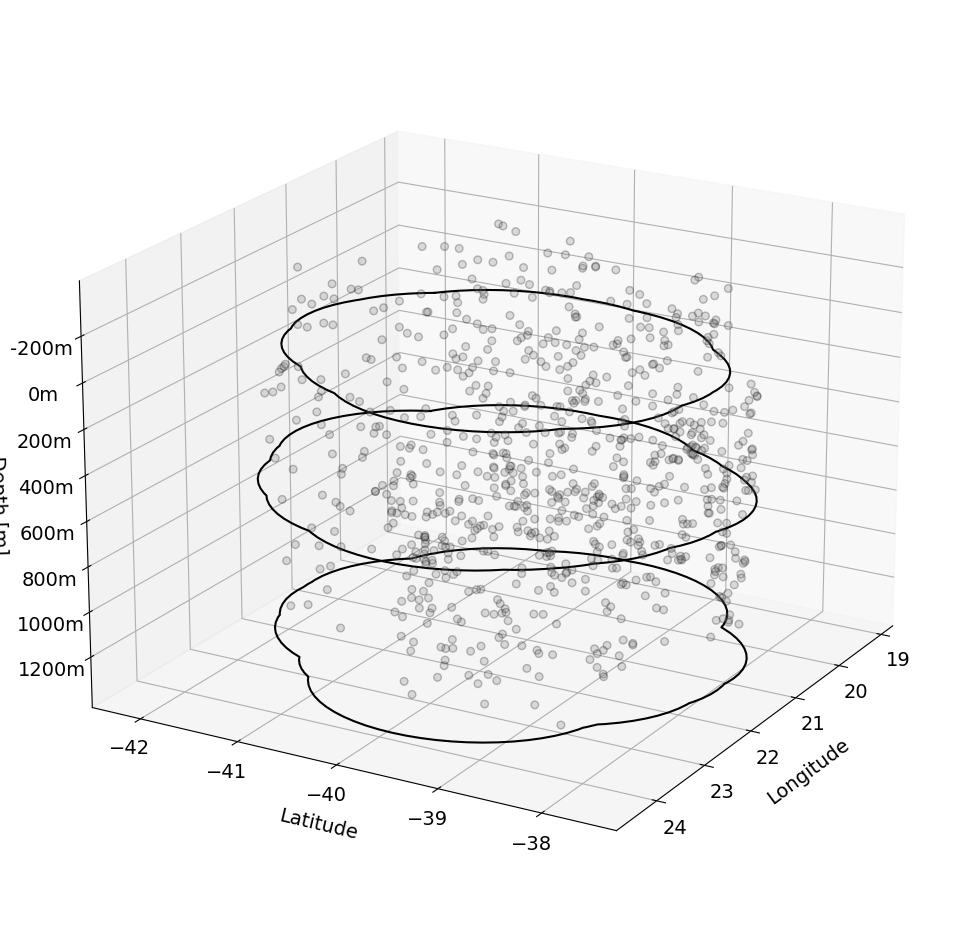

In [15]:
vortex_index = 13
vortex = vocc.vortices_[vortex_index]


# plot a three dimensional plot showing the layering of the vortex in the depth 


# create a 3d plot
fig = plt.figure(figsize= (12,12))
ax = fig.add_subplot(111, projection='3d')

# looking at the plot from the bottom
ax.view_init(azim=30, elev=20)

# plot the depth layers
for depth_i, d in enumerate(np.unique(vortex.pixels[:, 3])):
    # check if depth_polyon is a MultiPolygon and take the area of all polygons
    
    D = coordinates[: , 4]
    D_binned = np.digitize(D, bins = -depth_layers[::DEPTH_STRIDE])
    coordinates_in_depth = coordinates[D_binned == int(d)]

    if isinstance(vortex.depth_polygon[depth_i], MultiPolygon):

        for polygon in vortex.depth_polygon[depth_i].geoms:
            lons = np.atleast_1d(polygon.exterior.coords.xy[0])
            lats = np.atleast_1d(polygon.exterior.coords.xy[1])
            coords = np.stack((lons, lats)).T
            ax.plot(coords[:, 0], coords[:, 1], -depth_layers[::DEPTH_STRIDE][int(d)] * np.ones_like(coords[:, 0]), color='red')

    else:
        lons = np.atleast_1d(vortex.depth_polygon[depth_i].exterior.coords.xy[0])
        lats = np.atleast_1d(vortex.depth_polygon[depth_i].exterior.coords.xy[1])
        coords = np.stack((lons, lats)).T
        ax.plot(coords[:, 0], coords[:, 1], -depth_layers[::DEPTH_STRIDE][int(d)] * np.ones_like(coords[:, 0]), color='black')

        print(coordinates_in_depth.shape)
        # plot the particles
        coordinates_in_polygon = [coordinate for coordinate in coordinates_in_depth if vortex.depth_polygon[depth_i].contains(Point(coordinate[0], coordinate[1]))]
        coordinates_in_polygon = np.array(coordinates_in_polygon)
        
        ax.scatter(coordinates_in_polygon[:, 0], coordinates_in_polygon[:, 1], coordinates_in_polygon[:,4], color='grey', edgecolor='black', s=30, alpha = .25)


ax.set_ylabel('Latitude', labelpad=10)
ax.set_xlabel('Longitude', labelpad=10)


# ax.set_zticks(-depth_layers[::DEPTH_STRIDE])
# ax.set_zticklabels(np.round(-depth_layers[::DEPTH_STRIDE], 2))
ax.set_zticklabels([f"{-i}m" for i in range(-1400, 201, 200)])
ax.tick_params(axis='z', which='major', pad=8)
ax.set_zlabel('Depth [m]', labelpad=15)


fig.tight_layout()

plt.savefig('../fig/65_one_eddy.png')